In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns


# Colour codes for concave and sigmoid curves:
concave_colour = '#466be8'
sigmoid_colour = '#f77150'

plot_dpi = 300 #dpi at which plots will be saved


## 1. Discrete RPS Model:

The RPS Model can also be applied to a discrete time setting. Time $t$ now passes in discrete steps, $t \in = 1, 2, 3 \dots $ . On each step, the learner practices with probability $p_{prac} \in [0, 1]$. If they practice, their skill goes up with an amoun that depends on the learning curve. If they do not practice (with probability $1-p_{prac}$), they will forget a fraction of the skill. We use $S_{t+1} = k \cdot S_{t}$, where $ 0 \leq k \leq 1$ is the retention factor, which is related to the exponential forgetting rate $\beta$ as follows: 

$$ k = e^{-\beta}$$
or, equivalently: $$ \beta = -\ln(k) $$





In [19]:
# Helper Functions:

def practice_prob(s, a, b):
    """Probability of practicing given skill s, and parameters a and b."""
    p = a + b*S # Linear practice function
    return p

def learn_skill(S, alpha=0.1, lc='sigmoid', S_max = 1):
    if lc=='sigmoid':
        S_next = S + alpha*S*(S_max - S) 
    elif lc== 'concave':
        S_next = S + alpha*(S_max - S) 

    return S_next


def forget_skill(S, retention=0.9):
    """
    Note: retention is related to forgetting rate beta as:
        retention = exp(-beta)
    One can use either forgetting rate beta or retention factor (0 < retention < 1). 
    Both are equivalent.
    """
    S_next = S*retention
    return S_next


def plot_traj_hist_discreteRPS(s_mat, n_learners, t_max, plot_col, 
                               bw_adjust=0.5, save_location=False, save_dpi=512):
    """Plot learning trajectories and histogram of final skills for discrete RPS model."""  

    # make dataframe from list of final skills:
    df_finalS = pd.DataFrame(s_mat[:,-1], columns=['final_skills'])

    # Create Figure and Subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [2, 1]})

    for i in range(n_learners):
        # Plot each trajectory
        ax1.plot(list(range(t_max+1)), s_mat[i, :], '-', linewidth=0.2, alpha=0.7, color=plot_col)  
            
    ax1.set_title('Learning Trajectories - Discrete RPS', fontsize=20)
    ax1.set_xlim(1, t_max)  # Set x-axis limit based on maximum time
    ax1.set_ylim(0, 1)
    ax1.set_xlabel('Time', fontsize=22)
    ax1.set_ylabel('Skill',  fontsize=22)


    # Creating the histogram on the right using seaborn
    sns.kdeplot(df_finalS, ax=ax2, y='final_skills', color=plot_col, 
                alpha=0.7, fill=True, bw_adjust=bw_adjust)

    ax2.set_title('Distribution of Final Skills', fontsize=16)
    ax2.set_xlabel('')
    ax2.set_ylabel('Skill', fontsize=22)
    ax2.set_xticks([])
    ax2.set_ylim(ax1.get_ylim())  # Match y-limits to line plot y-axis
    ax2.yaxis.tick_right()  # Move y-axis ticks to the right
    ax2.yaxis.set_label_position("right")  # Move y-axis label to the right

    plt.tight_layout()  # Adjust layout to fit
    if save_location != False:
        plt.savefig(save_location, dpi=save_dpi)
    plt.show()        


### 1.1  Run Simulation with Discrete RPS Model:

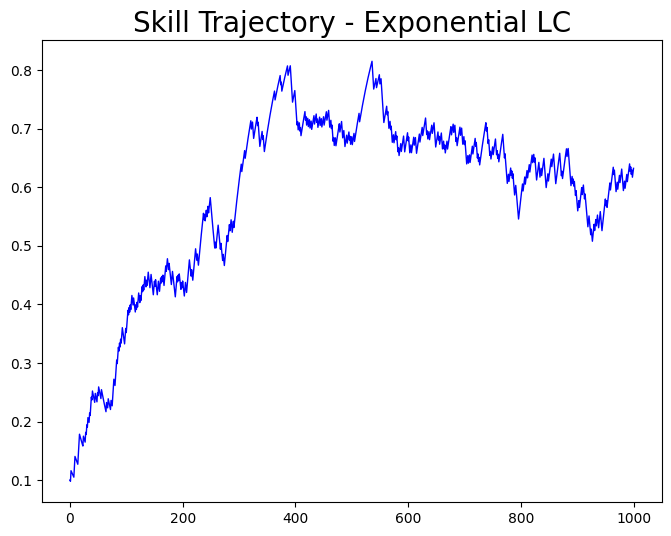

In [26]:
t_max = 1000 # now steps of time

# Initial Conditions:
s0 = 0.1 # initial skill
p0 = 0.1 # initial prob. of practice

# Individual Parameters:
a = 0.3 # min. practice prob.
b = 0.6 # success sensitivity
alpha = 0.02 # learning rate
beta = 0.02 # forgetting rate


# --- simulate one concave learner ----
t_list = np.arange(t_max+1)
s_list = [s0]
p_list = [p0]
prac_list = []

for t in range(t_max):
    s_ = s_list[-1]
    p_ = p_list[-1]

    # Did the learner practice?
    prac = np.random.binomial(n=1, p=p_) # 1 with prob p, 0 else
    prac_list.append(prac)    
    
    # Update skill
    if prac==1: # if learner practiced
        s_new = learn_skill(s_, alpha=alpha, lc='concave', S_max = 1)
    else: # did not practice
        s_new = forget_skill(s_, retention=np.exp(-beta))
    s_list.append(s_new)

    # update prob. of practice:
    p_new = a + b*s_new
    p_list.append(p_new)
    
#----  end of sim ----


# Plotting results:
plt.figure(figsize=(8,6))
plt.plot(t_list, s_list, label='Skill (S)', color='blue', lw=1)
#plt.plot(t_list, p_list, label='Practice Probability (p)', color='orange', lw=3)
plt.title('Skill Trajectory - Exponential LC', fontsize=20)
plt.show()


## 2. Simulation - Learning Curve Comparison

### 2.1 Exponential (Concave) Learning Curve:

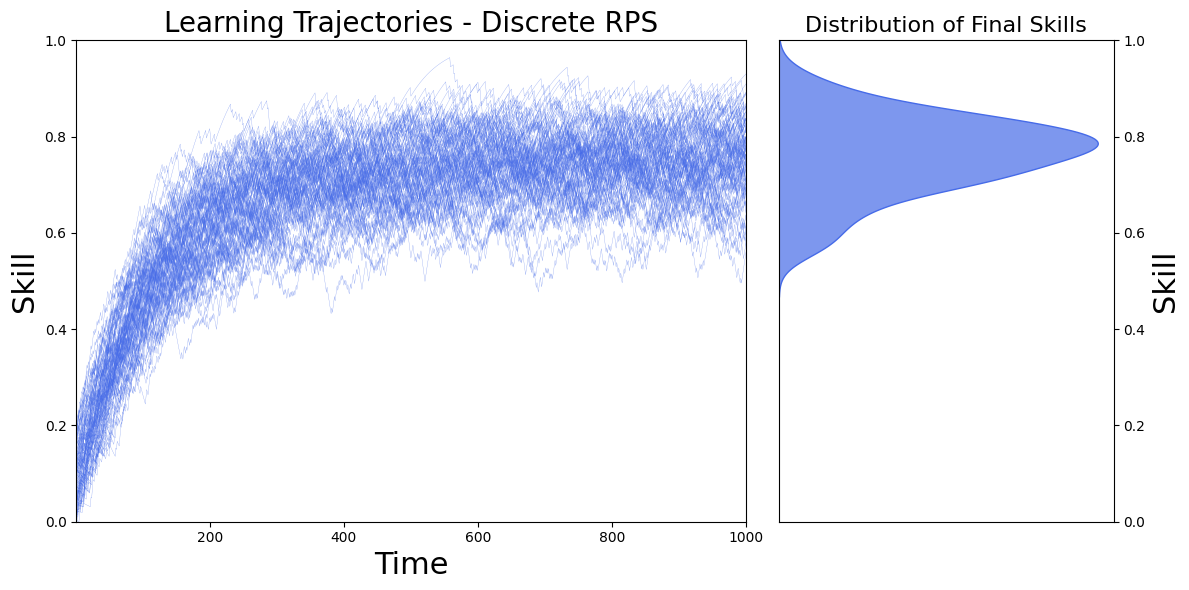

In [34]:
np.random.seed(13)

# Individual Parameters:
a = 0.3 # min. practice prob.
b = 0.6 # success sensitivity
alpha = 0.02 # learning rate
beta = 0.02 # forgetting rate


# simulate multiple learners
n_learners = 100
t_list = np.arange(t_max+1)
s0_list = np.random.uniform(0, 0.2, n_learners) # initial skill
p0_list = np.random.uniform(0, 0.2, n_learners) # initial prob. of practice

s_mat_exp = np.zeros((n_learners, t_max+1))
p_mat_exp = np.zeros((n_learners, t_max+1)) 
s_mat_exp[:,0] = s0_list
p_mat_exp[:,0] = p0_list
prac_mat_log = np.zeros((n_learners, t_max))

for i in range(n_learners):
    s_list = [s0_list[i]]
    p_list = [p0_list[i]]
    for t in range(t_max):
        s_ = s_list[-1]
        p_ = p_list[-1]

        # Did the learner practice?
        prac = np.random.binomial(n=1, p=p_) # 1 with prob p, 0 else
        prac_mat_log[i,t] = prac    

        # Update skill
        if prac==1: # if learner practiced
            s_new = learn_skill(s_, alpha=alpha, lc='concave', S_max = 1)
        else: # did not practice
            s_new = forget_skill(s_, retention=np.exp(-beta))
        s_list.append(s_new)

        # update prob. of practice:
        p_new = a + b*s_new
        p_list.append(p_new)

    s_mat_exp[i,:] = s_list
    p_mat_exp[i,:] = p_list

#----  end of sim ----

# ---- Plotting ----
plot_traj_hist_discreteRPS(s_mat_exp, n_learners, t_max, concave_colour, bw_adjust=1, 
                           save_location='../plots/discreteRPS_exp_traj_hist.jpg', save_dpi=512)


### 2.2 Logistic (Sigmoid) Learning Curve



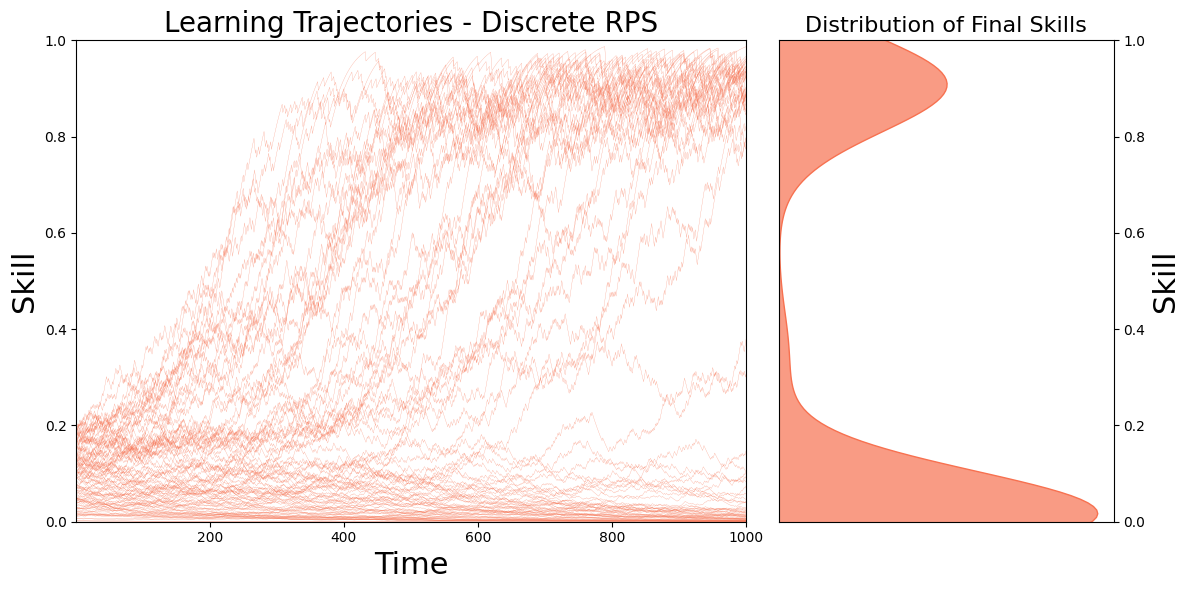

In [35]:
np.random.seed(13)  

# Individual Parameters:
a = 0.3 # min. practice prob.
b = 0.6 # success sensitivity
alpha = 0.04 # learning rate
beta = 0.02 # forgetting rate

# simulate multiple learners
t_list = np.arange(t_max+1)
s0_list = np.random.uniform(0, 0.2, n_learners) # initial skill
p0_list = np.random.uniform(0, 0.2, n_learners) # initial prob. of practice

s_mat_log = np.zeros((n_learners, t_max+1))
p_mat_log = np.zeros((n_learners, t_max+1)) 
s_mat_log[:,0] = s0_list
p_mat_log[:,0] = p0_list
prac_mat_log = np.zeros((n_learners, t_max))

for i in range(n_learners):
    s_list = [s0_list[i]]
    p_list = [p0_list[i]]
    for t in range(t_max):
        s_ = s_list[-1]
        p_ = p_list[-1]

        # Did the learner practice?
        prac = np.random.binomial(n=1, p=p_) # 1 with prob p, 0 else
        prac_mat_log[i,t] = prac    

        # Update skill
        if prac==1: # if learner practiced
            s_new = learn_skill(s_, alpha=alpha, lc='sigmoid', S_max = 1)
        else: # did not practice
            s_new = forget_skill(s_, retention=np.exp(-beta))
        s_list.append(s_new)

        # update prob. of practice:
        p_new = a + b*s_new
        p_list.append(p_new)

    s_mat_log[i,:] = s_list
    p_mat_log[i,:] = p_list

#----  end of sim ----

# ---- Plotting ----
plot_traj_hist_discreteRPS(s_mat_log, n_learners, t_max, sigmoid_colour, bw_adjust=.5, 
                           save_location='../plots/discreteRPS_log_traj_hist.jpg', save_dpi=512)

##  Conclusion

Thus quitting is seen in the logistic learning curve case, but not in the exponential where all outcomes are qualitatively the same. Bifurcation is seen in the case of the logistic and more generally sigmoid learning curve.